In [2]:
import numpy as np
import itertools
import astropy.cosmology as cosmology
import scipy.optimize as spo
import scipy.stats as sps
from scipy.stats import norm
import scipy.linalg as la
import scipy as sp
import emcee
#import corner
from datetime import datetime
import hickle
import bisect
import daft
import cProfile
from io import StringIO
import pstats
import sys
import pylab as pl
from sklearn.metrics import confusion_matrix
epsilon = sys.float_info.min
log_epsilon = sys.float_info.min_exp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
colors = 'rbgcymk'
import h5py
#h5py.run_tests()

In [3]:
def safe_log(arr, threshold=epsilon):
    shape = np.shape(arr)
    flat = arr.flatten()
    logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    return logged

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

all keys in truth: 
dict_keys(['data', 'id', 'phi', 'theta'])
n_zs truth:  400
all keys in data: 
dict_keys(['host interim ln prior', 'id', 'interim ln posteriors', 'interim ln prior', 'ln host selection function', 'ln prior info', 'ln selection function', 'ln sn selection function', 'mu_bins', 'sn interim ln prior', 'types', 'z_bins'])
n_types:  3
n_zs:  100
(400, 3, 100, 100) shape post
num_sne:  400
n_mus:  100
CID_1 0.447362850928 42.06871472803357 CID_1 0.2154 40.0807087631
CID_7 0.286668193098 40.92987424587921 CID_7 0.237 40.248812663
CID_0 0.391424367681 41.72266831254245 CID_0 0.2118 40.0526914464


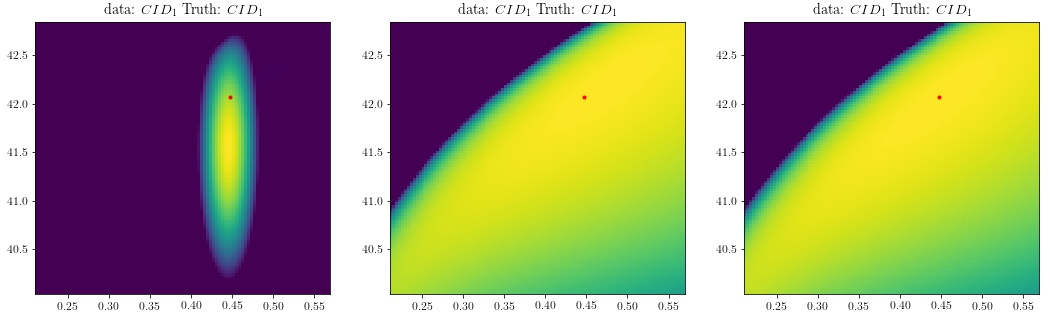

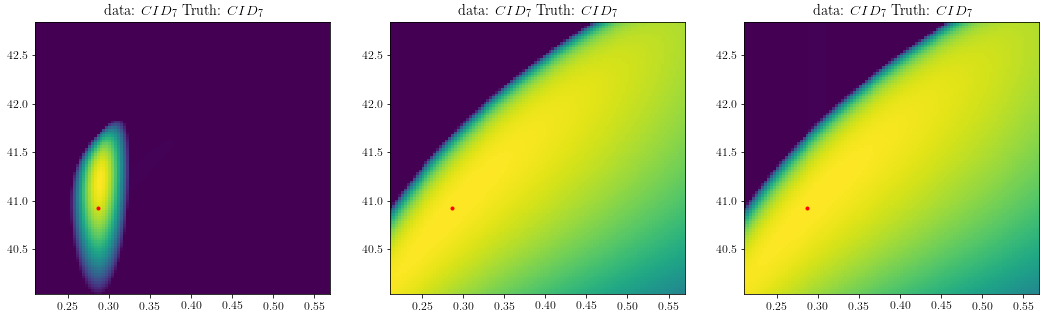

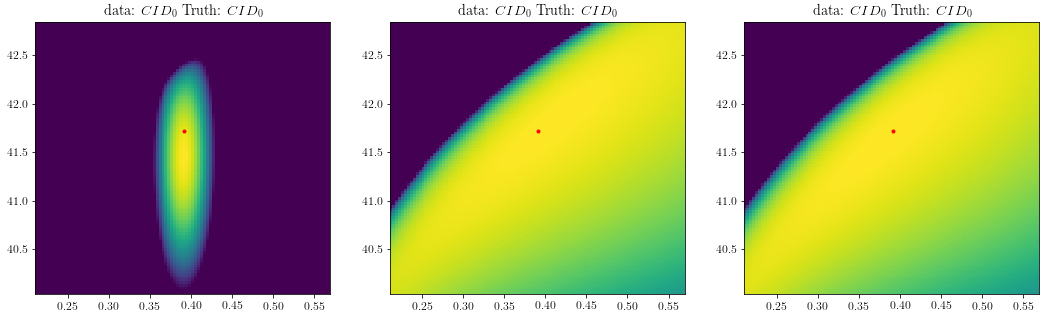

In [4]:
hickle.load_dataset
with open('data/data.hkl', 'r+') as in_file:
    sim_info = hickle.load(in_file)

with open('data/truth.hkl', 'r+') as in_file:
    truth_info = hickle.load(in_file)
    
    
print('all keys in truth: ')
print(truth_info.keys())
    
true_data = truth_info['data']
#print(true_data)

true_zs = [true_param['z'] for true_param in true_data]

print('n_zs truth: ', len(true_zs))
true_mus = [true_param['mu'] for true_param in true_data]

true_types = [true_param['t'] for true_param in true_data]
true_id = truth_info['id']

#true_types = true_data['t']
#true_z = true_data['z']
#true_mu=true_data['mu']

print('all keys in data: ')
print(sim_info.keys())

types = sim_info['types']
n_types = len(types)
print('n_types: ', n_types)

z_bins = sim_info['z_bins']
z_difs = z_bins[1:] - z_bins[:-1]
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.
n_zs = len(z_difs)
sn_id = sim_info['id']


print('n_zs: ', n_zs)

mu_bins = sim_info['mu_bins']

ln_int_post = sim_info.get('interim ln posteriors')
num_sne = np.shape(ln_int_post)[0]

print(np.shape(ln_int_post), 'shape post')
print('num_sne: ', num_sne)


#pl.figure(100)
#for s in range(num_sne):
    #print(true_id[s], true_zs[s], true_mus[s], sn_id[s], z_mids[s], mu_mids[s])
#    pl.plot(true_zs[s], z_bins[s] , marker='.', linestyle='None')
    
    
#pl.xlabel('true z')
#pl.ylabel('data z')
mu_difs = mu_bins[1:] - mu_bins[:-1]
#print(z_bins)
#print(z_difs)
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.
n_mus = len(mu_difs)
print('n_mus: ', n_mus)



fig = plt.figure(figsize=(n_types*6, 5))
p = 0
for s in [1,7,0]:
#range(5):
    fig = plt.figure(figsize=(n_types*6, 5))
    print(true_id[s], true_zs[s], true_mus[s], sn_id[s], z_mids[s], mu_mids[s])
    p = 0
    for t in range(3):
        p += 1
        
        #print(sn_id[s], true_id[s])
        plt.subplot(1, n_types, p)
        plt.pcolormesh(z_bins, mu_bins, ln_int_post[s,t,:,:].T, cmap='viridis')
        plt.scatter(true_zs[s], true_mus[s], marker='.', color='r', linestyle='None')
        plt.title(r'data: $%s$ Truth: $%s$'%(sn_id[s], true_id[s]))

In [4]:
#print(true_types)

## Integrating over both mu and z to get P(type)

In [5]:
type_tmp=np.zeros((num_sne,3))

# Making sure to convert to posterior (not log post) and then do simple integral. This should be improved later
# scipy.integrate.simps(y, x=None, dx=1, axis=-1, even='avg')

#for zi in range(1,n_zs):
#    for mui in range(1,n_mus):
        
type_tmp[:,:] =np.dot(np.dot(np.exp(ln_int_post[:,:,:,:]),mu_difs), z_difs)
        
        #*(z_bins[zi]-z_bins[zi-1])*(mu_bins[mui]-mu_bins[mui-1])


# Ensure that the probabilities are normalised
norm = np.sum(type_tmp, axis=1)
type_tmp[:,0]=type_tmp[:,0]/norm
type_tmp[:,1]=type_tmp[:,1]/norm
type_tmp[:,2]=type_tmp[:,2]/norm


## Now we assign the classified type by the highest probability.

Confusion matrix, without normalization
[[172   0   0]
 [  7  27  10]
 [ 19  22 143]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.16  0.61  0.23]
 [ 0.1   0.12  0.78]]


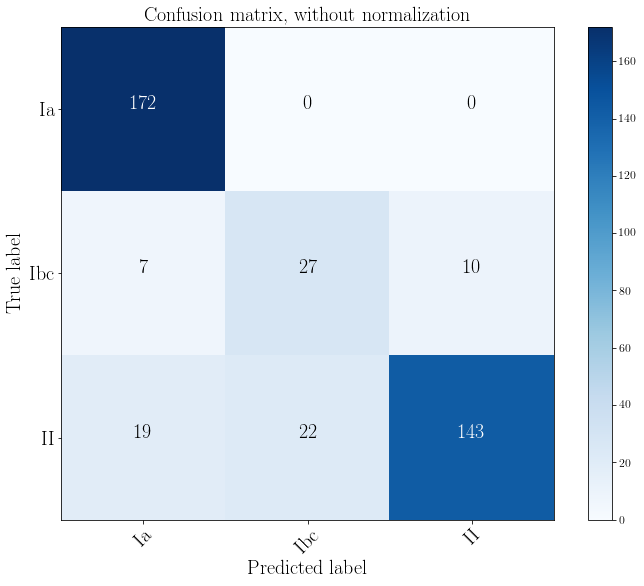

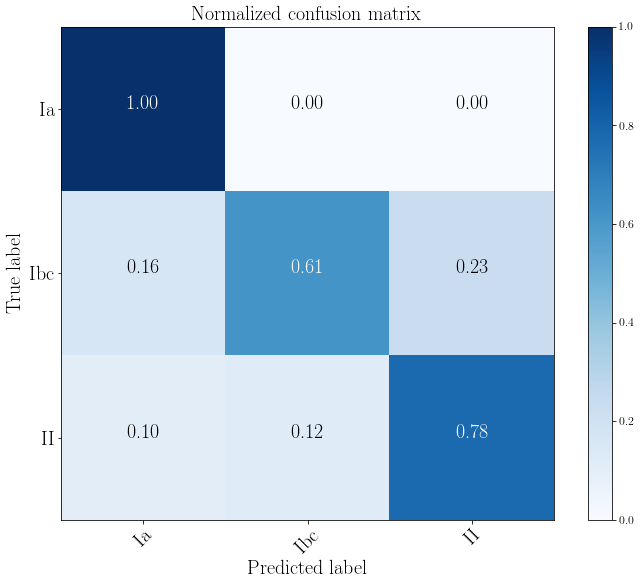

In [6]:
type_converter = {'Ia': 0, 'Ibc': 1, 'II': 2}
true_types_indices = [type_converter[m] for m in true_types]
true_type = np.argmax(type_tmp, axis=1)
obs_type = true_type

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

# conf_mat = skl.metrics.confusion_matrix(true_types_indices, true_type)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(true_types_indices, obs_type)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pl.figure(5,figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=types,
                      title='Confusion matrix, without normalization')
plt.savefig('unNormalised_confusion.png')
# Plot normalized confusion matrix
pl.figure(4,figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=types, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('Normalised_confusion.png')

In [7]:
# true_types_indices = [type_converter[m] for m in true_types]
# true_type = np.argmax(type_tmp, axis=1)# Planck 2015 results XIV. Dark energy and modified gravity - Figure 3

# plt.plot(true_types_indices, true_type)
# conf_mat = skl.metrics.confusion_matrix(true_types_indices, true_type)
true_H0 = 67.9
true_Ode0 = 0.693
true_Om0 = 1. - true_Ode0
true_w0 = -1.09
true_wa = -0.20
true_hyperparams = np.array([true_w0, true_wa])
n_hyperparams = len(true_hyperparams)
#true_cosmo = cosmology.FlatLambdaCDM(H0=true_H0, Om0=true_Om0)
true_cosmo = cosmology.w0waCDM(true_H0, true_Om0, true_Ode0, w0=true_w0, wa=true_wa)

#for n in range(num_sne):
#    true_params[n]['mu'] = true_cosmo.distmod(true_params[n]['z']).value

In [8]:
a = np.array([[10, 7, 4], [3, 2, 1]])
print(a)
print(np.percentile(a, 50, axis=0))
print(np.percentile(a, 50, axis=1))

[[10  7  4]
 [ 3  2  1]]
[ 6.5  4.5  2.5]
[ 7.  2.]


In [9]:
#print(true_types_indices)
#print(obs_type)
#print(true_types_indices - obs_type)

Let's make a Hubble plot assuming every SN is Ia, and contrast with the mu assuming true types:

In [10]:
import matplotlib as mpl

class ReNormColormapAdaptor(mpl.colors.Colormap):
    """ Colormap adaptor that uses another Normalize instance
    for the colormap than applied to the mappable. """
    def __init__(self,base,cmap_norm,orig_norm=None):
        if orig_norm is None:
            if isinstance(base,mpl.cm.ScalarMappable):
                orig_norm = base.norm
                base = base.cmap
            else:
                orig_norm = mpl.colors.Normalize(0,1)
        self._base = base
        if (
            isinstance(cmap_norm,type(mpl.colors.Normalize))
            and issubclass(cmap_norm,mpl.colors.Normalize)
        ):
            # a class was provided instead of an instance. create an instance
            # with the same limits.
            cmap_norm = cmap_norm(orig_norm.vmin,orig_norm.vmax)
        self._cmap_norm = cmap_norm
        self._orig_norm = orig_norm

    def __call__(self, X, **kwargs):
        """ Re-normalise the values before applying the colormap. """
        return self._base(self._cmap_norm(self._orig_norm.inverse(X)),**kwargs)

    def __getattr__(self,attr):
        """ Any other attribute, we simply dispatch to the underlying cmap. """
        return getattr(self._base,attr)

In [7]:
lninterimposteriors = sim_info['interim ln posteriors']
n_SNe = len(lninterimposteriors)
print(n_SNe)
true_types = [true_param['t'] for true_param in true_data]
type_converter = {'Ia': 0, 'Ibc': 1, 'II': 2}
true_types_indices = [type_converter[m] for m in true_types]

type_tmp=np.zeros((n_SNe,3))
type_tmp[:,:] =np.dot(np.dot(np.exp(lninterimposteriors[:,:,:,:]),mu_difs), z_difs)
obs_type = np.argmax(type_tmp, axis=1)

muerr_lo = np.zeros((n_SNe, n_types))
muerr_hi = np.zeros((n_SNe, n_types))

zerr_lo = np.zeros((n_SNe, n_types))
zerr_hi = np.zeros((n_SNe, n_types))

xy = np.empty((2, n_SNe, n_types))

muerr_lo_ia = np.zeros((n_SNe, 1))
muerr_hi_ia = np.zeros((n_SNe, 1))

mu_cosmo=np.zeros((n_SNe, 1))

zerr_lo_ia = np.zeros((n_SNe, 1))
zerr_hi_ia = np.zeros((n_SNe, 1))

xy_ia = np.empty((2, n_SNe,1))

two_sigma_percentiles = [0.0228,0.5,0.9772]
pia = np.zeros(n_SNe)



for sn in range(n_SNe):
    for tn in range(n_types):
        zm = lninterimposteriors[sn, tn, :, :]
        hm = lninterimposteriors[sn, tn, :, :].T
        pia[sn] = type_tmp[sn, 0]
        z_prob  = np.dot(np.exp(zm), mu_difs[:])
        mu_prob = np.dot(np.exp(hm), z_difs)
        
        xy[0][sn][tn] = z_bins[np.argmax(z_prob)]
        xy[1][sn][tn] = mu_bins[np.argmax(mu_prob)]
        
        z_prob   = np.dot(np.exp(zm), mu_difs[:])
        tot_prob = np.sum(z_prob)
        cum_prob = np.array([])
        
        
        zm_ia = lninterimposteriors[sn, 0, :, :]
        hm_ia = lninterimposteriors[sn, 0, :, :].T
        
        z_prob_ia  = np.dot(np.exp(zm_ia), mu_difs[:])
        mu_prob_ia = np.dot(np.exp(hm_ia), z_difs)
        
        xy_ia[0][sn][0] = z_bins[np.argmax(z_prob_ia)]
        xy_ia[1][sn][0] = mu_bins[np.argmax(mu_prob_ia)]
        
    
    
        
        tot_prob_ia = np.sum(z_prob_ia)
        cum_prob_ia = np.array([])
        
        for i in range(len(z_bins)):
            cum_prob = np.append(cum_prob, np.sum(z_prob[:i])/tot_prob)
            cum_prob_ia = np.append(cum_prob_ia, np.sum(z_prob_ia[:i])/tot_prob_ia)
            
            
        zspline = interp1d(cum_prob, z_bins)
        zlow,zmed,zhigh = zspline(two_sigma_percentiles)
        zspline_ia = interp1d(cum_prob_ia, z_bins)
        zlow_ia,zmed_ia,zhigh_ia = zspline_ia(two_sigma_percentiles)
        
        mu_cosmo[sn]=true_cosmo.distmod(zmed_ia).value
        
        mu_prob  = np.dot(np.exp(hm),z_difs)
        tot_prob = np.sum(mu_prob)
        cum_prob = np.array([])
        
        mu_prob_ia  = np.dot(np.exp(hm_ia),z_difs)
        tot_prob_ia = np.sum(mu_prob_ia)
        cum_prob_ia = np.array([])
        
        for i in range(len(mu_bins)):
            cum_prob = np.append(cum_prob, np.sum(mu_prob[:i])/tot_prob)
            cum_prob_ia = np.append(cum_prob_ia, np.sum(mu_prob_ia[:i])/tot_prob_ia)
        
        muspline = interp1d(cum_prob, mu_bins)
        mulow,mumed,muhigh = muspline(two_sigma_percentiles)

        muspline_ia = interp1d(cum_prob_ia, mu_bins)
        mulow_ia,mumed_ia,muhigh_ia = muspline_ia(two_sigma_percentiles)
        
        #print(zlow,mulow)
        
        zerr_lo[sn][tn]  = zmed-zlow
        zerr_hi[sn][tn]  = zhigh-zmed
        muerr_lo[sn][tn] = mumed-mulow
        muerr_hi[sn][tn] = muhigh-mumed
        
        zerr_lo_ia[sn][0]  = zmed_ia-zlow_ia
        zerr_hi_ia[sn][0]  = zhigh_ia-zmed_ia
        muerr_lo_ia[sn][0] = mumed_ia-mulow_ia
        muerr_hi_ia[sn][0] = muhigh_ia-mumed_ia
        
        
        if pia[sn] < 0.15:
            xy_ia[1][sn][0] = mu_cosmo[sn] + 0.35*np.random.randn()*(xy_ia[0][sn][0])

400


NameError: name 'interp1d' is not defined

In [25]:
import scipy as sp
C1 = np.mat(np.zeros((2,2)))
C1[0,0]=C1[1,1]=0.1
C2 = np.mat(np.zeros((2,2)))
C2[0,0]=C2[1,1]=0.2
C1_0p5=sp.linalg.sqrtm(C1)
C2_0p5=sp.linalg.sqrtm(C2)
C12=C1_0p5*C2_0p5
print(C12)
print(C1)
print(C2)
print(np.sqrt(0.1*0.2))

[[ 0.14  0.  ]
 [ 0.    0.14]]
[[ 0.1  0. ]
 [ 0.   0.1]]
[[ 0.2  0. ]
 [ 0.   0.2]]
0.141421356237


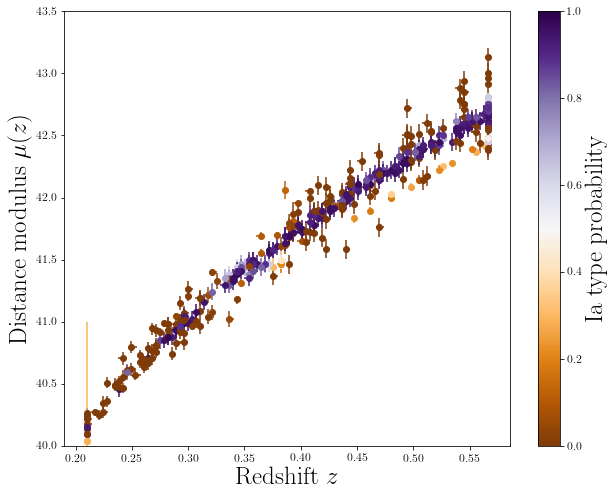

In [48]:
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.cm as cmx
vir=cm=plt.cm.PuOr
cNorm  = colors.Normalize(vmin=0, vmax=1)
#cNorm=colors.PowerNorm(gamma=1./2.)
#cnorm=colors.LogNorm()
#bounds = np.array([0, 0.25, 0.5, 1])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=4)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=vir)
sm = plt.cm.ScalarMappable(cmap=vir, norm=cNorm)


#cmap = ReNormColormapAdaptor(vir,colors.LogNorm(vmin=0,vmax=1))
#norm=plt.Normalize(vmin=0.6, vmax=1))


sm._A = []
pmin, pmax = log_epsilon, np.log(1./(min(z_difs) * min(mu_difs)))


pl.figure(10,figsize=(10,8))
ax = plt.subplot(111)
# plt.errorbar(zmedia[indsmuia], mumedia[indsmuia],yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='teal')
#plt.errorbar(xy_ia[0], xy_ia[1], yerr=muerria ,xerr=zerria, marker='o', linestyle='None', color='teal')
#ziavec = np.zeros(len(true_zs))
#muiavec = np.zeros(len(true_zs))
#colorVal = [] #np.zeros(len(indsmuia))]

#                  true_zs[indsmuia]
#muavec = true_mus[indsmuia]
#sortz=np.argsort(ziavec)
#print(ziavec)

#for i in range(len(true_zs)):
    
#    ziavec[i] = true_zs[i]
#    muiavec[i] = true_mus[i]
    
#for ic, ind in enumerate(indsmuia):
    #print(pia[ic],xy_ia[0,ic], xy_ia[1,ic] )
       

    #ziavec[ic] = true_zs[ind]
 #   muiavec[ic] = true_mus[ind]
 
#print(np.min(ziavec), np.max(ziavec))
#print(np.min(xy_ia[0,:]), np.max(xy_ia[0,:]))


#sortz=np.argsort(ziavec)
#true_muspl = interp1d(ziavec[sortz], muiavec[sortz])
#splined_mu = true_muspl(xy_ia[0,:])



for ic in range(len(xy_ia[0,:])):
    colorVal.append(scalarMap.to_rgba((pia[ic])))
    im=ax.errorbar(xy_ia[0,ic], (xy_ia[1,ic]), 
                   yerr=np.array([muerr_lo_ia[ic], muerr_hi_ia[ic]]), xerr=np.array([zerr_lo_ia[ic], zerr_hi_ia[ic]]) , marker='o', color=colorVal[ic])

    
#sm.set_cmap(ReNormColormapAdaptor(sm, colors.LogNorm))
cb=plt.colorbar(sm)
cb.set_label('Ia type probability', fontsize=25)
#pl.title('assuming every SN is Ia')
pl.xlabel(r'Redshift $z$',fontsize=25)
#pl.ylabel(r'$(\mu(z)-\mu_{true}(z))/\mu_{true}(z)$', fontsize=20)
pl.ylabel(r'Distance modulus $\mu(z)$', fontsize=25)
#pl.xscale('log')
#pl.yscale('log')
pl.ylim(40., 43.5)
#plt.xlim(0.15, 0.65)
pl.savefig('fakeHubble_assumeIa.png')
plt.show()
pl.close()